# Scenario

In the scenario, one agent wants to travel along a corridor with constant speed, avoiding the single obtacle. The obstacle is visible during the whole runs, the agent start at full speed towards the corridor and may start changing trajectory after the first control update.

The initial lateral position of agent and obstacle are picked randomly with the constraint that passing is always possible, i.e. that there is a gap of at least the agent size enlarged by its safety margin.

In [1]:
%%writefile scenario.yaml
type: CorridorWithObstacle
length: 1.0
width: 1.0
min_radius: 0.2
max_radius: 0.2
groups:
  -
    type: thymio
    number: 1
    radius: 0.08
    control_period: 0.05
    color: firebrick
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.12
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 10
      tau: 0.25
      eta: 0.5
      safety_margin: 0.05
      barrier_angle: 1.0
    state_estimation:
      type: Bounded
      range: 1.0
      update_static_obstacles: true

Overwriting scenario.yaml


In [2]:
import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_formats = ['svg']

In [3]:
import numpy as np
from navground import core, sim
import navground.learning.scenarios

with open('scenario.yaml') as f:
    scenario = sim.load_scenario(f.read())

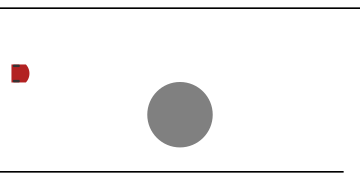

In [4]:
from navground.sim.notebook import display_in_notebook

world = sim.World()
scenario.init_world(world)

display_in_notebook(world, width=360)

In [5]:
from navground.sim.ui.video import display_video

display_video(world=world, time_step=0.1, duration=20.0, factor=5.0, display_width=360)

A typical run takes very little to compute

In [6]:
%%timeit
world = sim.World()
scenario.init_world(world)
world.run(200, 0.1)

517 μs ± 6.66 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
world.time

19.83333396911621

The task is simple but not trivial, even for the rule-based behavior like HL. In fact, sometimes, the gap on one side is almost good for the agent to pass safely, but not quite: it is possible that the agent is too near and does not manage to change side in time. In our scenario, `HL` is setup to that it will try to pass anyway (`barrier_angle` $<\pi/2$)  incurring in a violation of the safety margin. This event is relatively rare, and for the majority of runs, the agent passes safely. 

Let us plot few trajectories when using `HL`

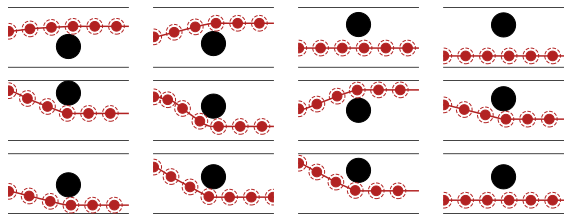

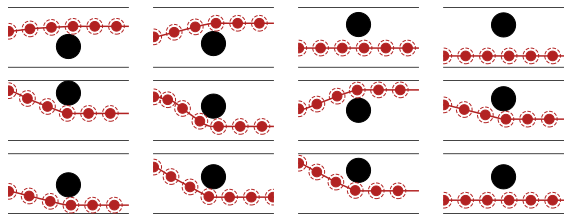

In [8]:
from matplotlib import pyplot as plt
from navground.sim.pyplot_helpers import plot_runs

exp = sim.Experiment(time_step=0.1, steps=300)
exp.scenario = scenario
exp.record_config.pose = True
exp.run(number_of_runs=12)

plot_runs(runs=exp.runs.values(), columns=4, with_agent=True, 
          world_kwargs={'in_box': True, 'no_ticks': True}, step=30, 
          agent_kwargs={'dot_radius': 0, 'with_safety_margin': True})

## Sensor

We want to learn doing the same task using a sensor

In [9]:
%%writefile sensors.yaml
- type: Boundary
  min_y: 0
  max_y: 1
  range: 1
- type: Discs
  number: 1
  range: 1
  max_speed: 0.0
  max_radius: 0.0
  include_valid: false
  name: obstacle

Overwriting sensors.yaml


that perceives

- the nearest point of the obstacle
- the distance to the left and right walls

The agent input will be 

- the sensing reading (see above)
- the own speed in body frame
- the own angular speed
- the own targer direction in body frame

and should output an acceleration command (linear and angular).

We measure the quality of the trajectoty by a reward that penalizes

- safety margin violations (violating by at most 1 cm is excused)
- not moving at full speed along the corridor

A trajectory cannot have more than 0 reward, which can happen only if the obstacle is not in the way.

In [10]:
import gymnasium as gym
from navground import sim
from navground.learning import ControlActionConfig, DefaultObservationConfig, io
from navground.learning.rewards import SocialReward
import navground.learning.scenarios

duration = 40.0
time_step = 0.1

action_config = ControlActionConfig(max_acceleration=1.0, max_angular_acceleration=10.0, 
                                    use_acceleration_action=True)

observation_config = DefaultObservationConfig(include_target_direction=True, include_velocity=True, 
                                              include_angular_speed=True, flat=False)

reward = SocialReward(safety_margin=0.04)

with open('sensors.yaml') as f:
    sensors = f.read()

with open('scenario.yaml') as f:
    scenario = sim.load_scenario(f.read())
    
env = gym.make('navground', 
    scenario=scenario,
    sensors=sensors,
    action=action_config,
    observation=observation_config,
    time_step=time_step,
    max_duration=duration,
    reward=reward)

io.save_env(env, 'env.yaml')

Let us look at the rewards using `HL`

In [11]:
from navground.learning.evaluation import evaluate_with_experiment_and_env

rewards, _ = evaluate_with_experiment_and_env(env, n_eval_episodes=1000, 
                                              return_episode_rewards=True)

print(f"Rewards: min={np.min(rewards):.2f}, mean={np.mean(rewards):.2f}, "
      f"median={np.median(rewards):.2f}, max={np.max(rewards):.2f}")

Rewards: min=-71.02, mean=-5.36, median=-3.95, max=0.00


and the run with lowest rewards

In [12]:
seed = int(np.argmin(rewards))

print(f"Minimal rewards {rewards[seed]:.2f} for seed={seed}")

Minimal rewards -71.02 for seed=158


In [13]:
world = sim.World()
scenario.init_world(world, seed=seed)
display_video(world=world, time_step=0.1, duration=20.0, factor=5.0, display_width=360)

which is one of the cases we discussed at the beginning, where the agent is passing on the "wrong" side of the obstacle.

In about 20% of the runs, the agent just goes straight

In [14]:
p_straight = sum(np.asarray(rewards) == 0) / len(rewards)
print(f"p_straight={p_straight:.1%}")

p_straight=22.2%


and in all the other runs it has to actually avoid the obstacles, incurring in a penalty 

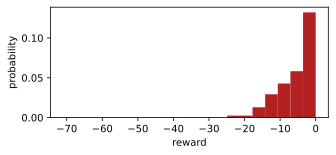

In [15]:
plt.figure(figsize=(5, 2))
plt.hist(rewards, bins=20, density=True, color='firebrick');
plt.xlabel('reward')
plt.ylabel('probability');

Finally, we have a look at the input/output distributions

In [16]:
from navground.learning import GroupConfig
from navground.learning.probes import GymProbe

In [17]:
exp = sim.Experiment(time_step=0.1, steps=300)
exp.scenario = scenario
exp.record_config.pose = True
exp.add_probe(GymProbe.with_env(env))
exp.run(number_of_runs=1000)

In [18]:
exp.runs[0].records

{'actions/0': <Dataset: shape (169, 2), dtype float64>,
 'observations/0/boundary_distance': <Dataset: shape (170, 2), dtype float32>,
 'observations/0/ego_angular_speed': <Dataset: shape (170, 1), dtype float32>,
 'observations/0/ego_target_direction': <Dataset: shape (170, 2), dtype float32>,
 'observations/0/ego_velocity': <Dataset: shape (170, 1), dtype float32>,
 'observations/0/obstacle/position': <Dataset: shape (170, 1, 2), dtype float32>,
 'poses': <Dataset: shape (169, 1, 3), dtype float32>,
 'rewards/0': <Dataset: shape (169,), dtype float64>}

In [19]:
actions = np.concatenate([np.asarray(run.get_record('actions/0')) for run in exp.runs.values()])
ego_target_direction = np.concatenate([np.asarray(run.get_record('observations/0/ego_target_direction')) for run in exp.runs.values()])
position = np.concatenate([np.asarray(run.get_record('observations/0/obstacle/position')) for run in exp.runs.values()])
boundary_distance = np.concatenate([np.asarray(run.get_record('observations/0/boundary_distance')) for run in exp.runs.values()])
ego_velocity = np.concatenate([np.asarray(run.get_record('observations/0/ego_velocity')) for run in exp.runs.values()])
ego_angular_speed = np.concatenate([np.asarray(run.get_record('observations/0/ego_angular_speed')) for run in exp.runs.values()])

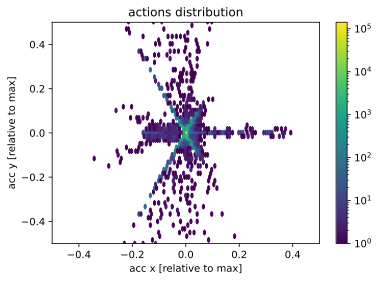

In [20]:
plt.figure(figsize=(6, 4))
plt.hexbin(*actions.T, bins='log');
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel('acc x [relative to max]')
plt.ylabel('acc y [relative to max]')
plt.colorbar()
plt.title('actions distribution');

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
i1 = ax1.hexbin(*ego_target_direction.T, bins='log');
ax1.axis('equal')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('relative target direction distribution');

i2 = ax2.hexbin(*position.T, bins='log');
ax2.axis('equal')
ax2.set_xlabel('x [m]')
ax2.set_ylabel('y [m]')
ax2.set_title('relative obstacle position distribution');

fig.colorbar(i1, ax=ax1)
fig.colorbar(i2, ax=ax2);

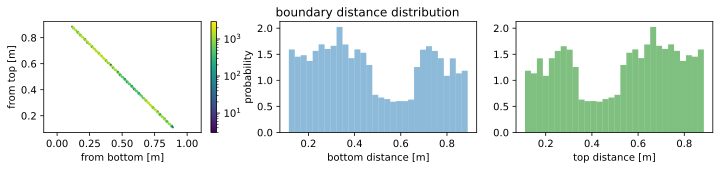

In [22]:
bottom, top = boundary_distance.T
fig, axs = plt.subplots(1, 3, figsize=(12, 2))
fig.suptitle('boundary distance distribution');

i = axs[0].hexbin(*boundary_distance.T, bins='log');
axs[0].set_xlabel('from bottom [m]')
axs[0].set_ylabel('from top [m]')
axs[0].axis('equal')
fig.colorbar(i, ax=axs[0])

axs[1].hist(bottom, bins=30, density=True, label="bottom", alpha=0.5);
axs[2].hist(top, bins=30, density=True, label="top", alpha=0.5, color='g');
axs[1].set_xlabel('bottom distance [m]')
axs[2].set_xlabel('top distance [m]')
axs[1].set_ylabel('probability');

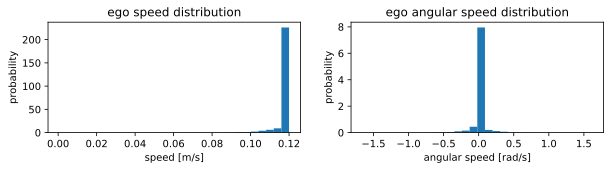

In [23]:
_, (ax1, ax2) = plt.subplots(figsize=(10, 2), ncols=2)
ax1.hist(ego_velocity.flatten(), bins=30, density=True);
ax1.set_xlabel('speed [m/s]')
ax1.set_ylabel('probability')
ax1.set_title('ego speed distribution');
ax2.hist(ego_angular_speed.flatten(), bins=30, density=True);
ax2.set_xlabel('angular speed [rad/s]')
ax2.set_ylabel('probability')
ax2.set_title('ego angular speed distribution');